## Main Topics 
    1: "data (prepare and load)",

    2: "build model",

    3: "fitting the model to data (training)",

    4: "making predictions and evaluating a model (inference)",

    5: "saving and loading a model",
    
    6: "putting it all together"


In [166]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.4.1+cpu'

Machine learning is a game of two parts:

1). Turn your data, whatever it is, into numbers (a representation).
2). Pick or build a model to learn the representation as best as possible.

 In this example linear regression is used to create the data with known parameters (things that can be learned by a model) and then PyTorch is utilized to see if we can build model to estimate these parameters using *gradient descent*.

In [167]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
# Guess shape of X and y
#print(f"shape of y is {y.shape}")

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

# Split data into training and test sets
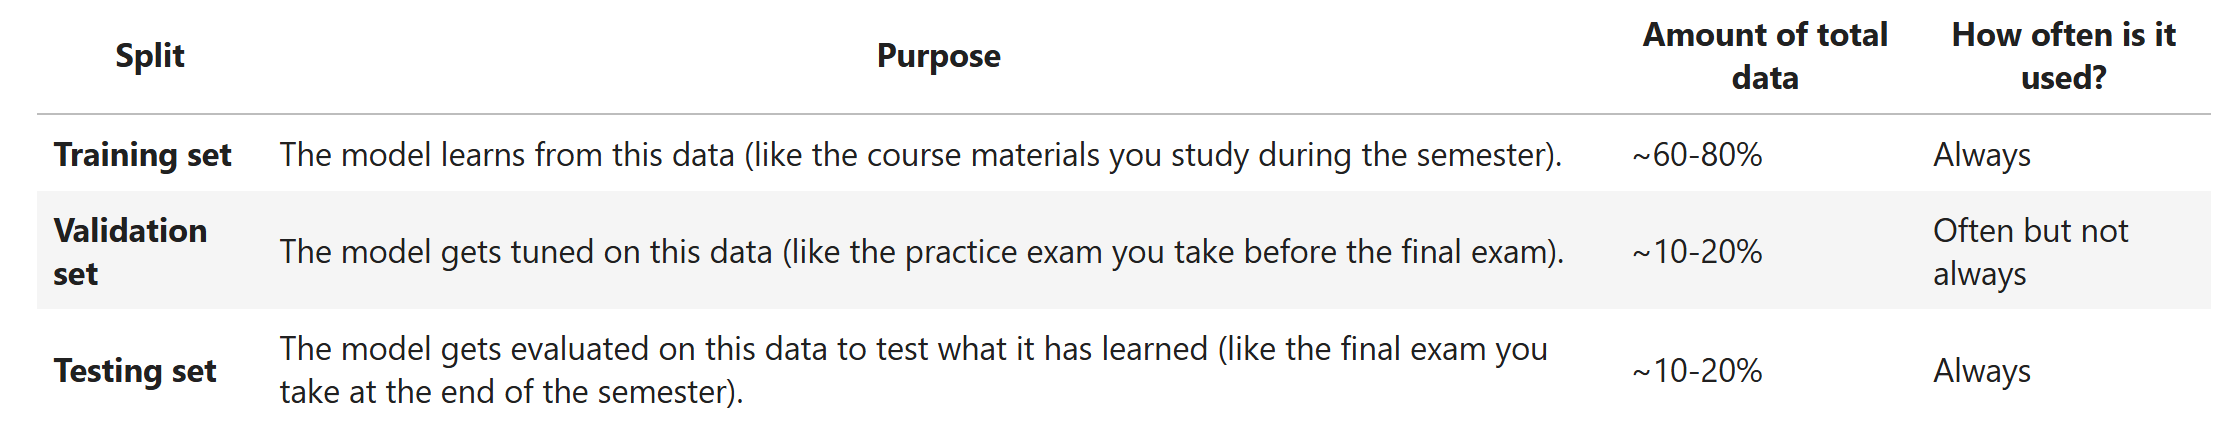

In [168]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [169]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=20, marker='v', label="Training data") # s is size of marker
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=20, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=20, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

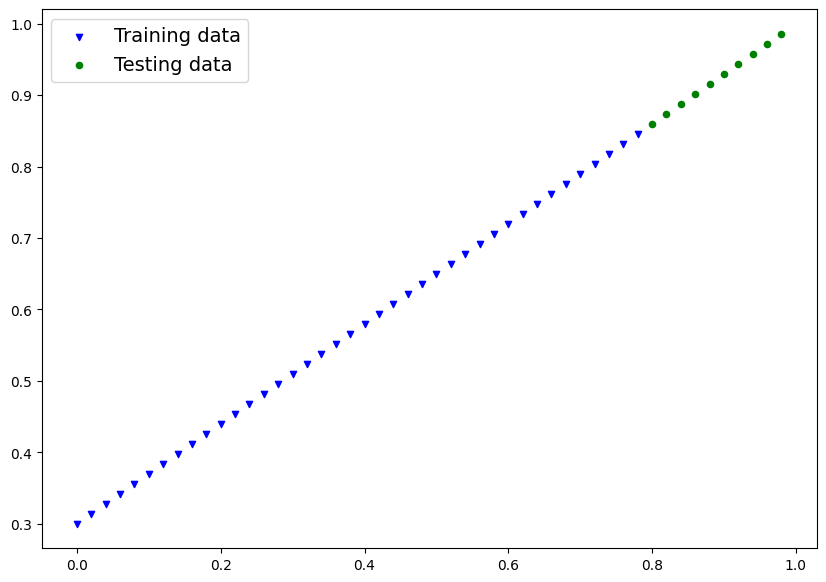

In [170]:
plot_predictions();


# 2. Build model

In [171]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

# PyTorch module	What does it do?
**torch.nn**	Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way).

**torch.nn.Parameter**	Stores tensors that can be used with nn.Module. If requires_grad=True gradients (used for updating model parameters via gradient descent) are calculated automatically, this is often referred to as "autograd".

**torch.nn.Module**	The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass nn.Module. Requires a forward() method be implemented.

**torch.optim**	Contains various optimization algorithms (these tell the model parameters stored in nn.Parameter how to best change to improve gradient descent and in turn reduce the loss).

**def forward()**	All nn.Module subclasses require a forward() method, this defines the computation that will take place on the data passed to the particular nn.Module (e.g. the linear regression formula above).

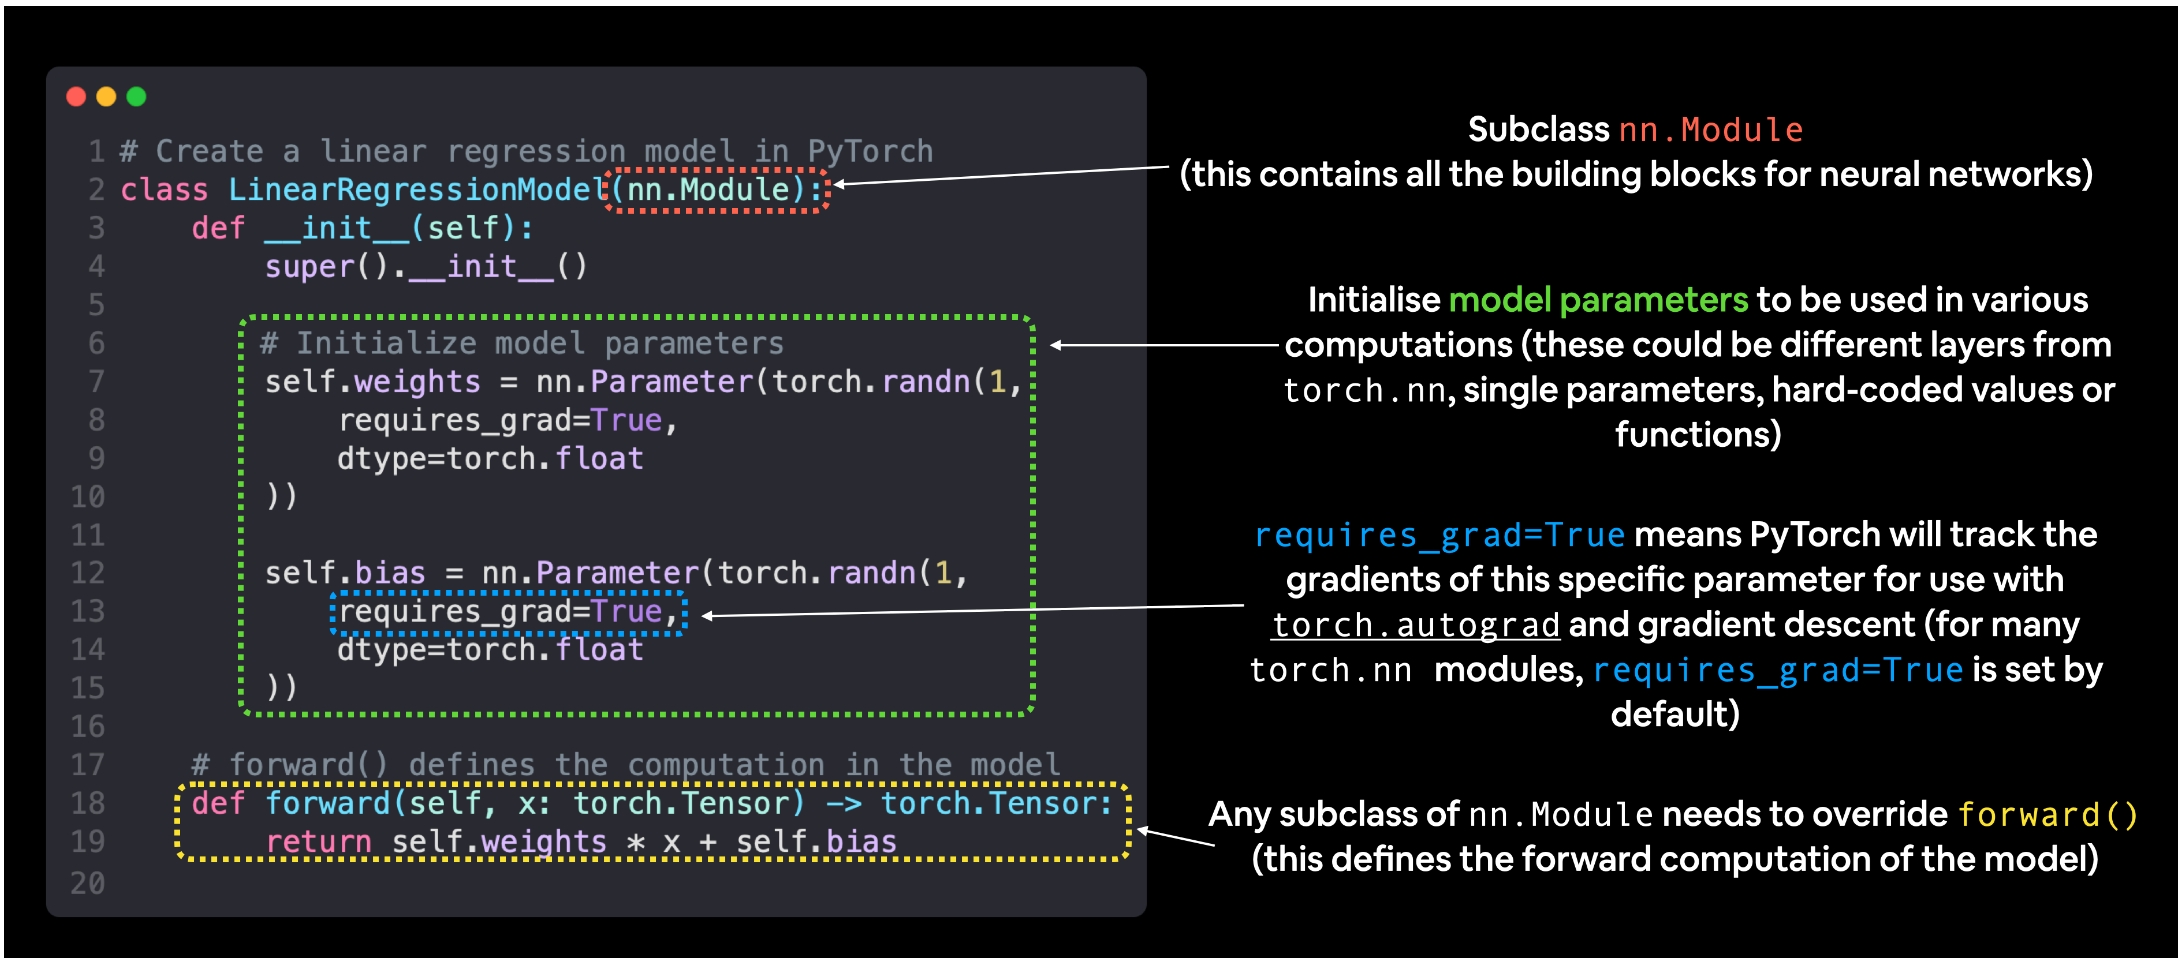


In [172]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [173]:
# List named parameters 
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making predictions using torch.inference_mode()

In [174]:
# Make predictions with model
with torch.inference_mode(): 
    y_preds = model_0(X_test)


In [175]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

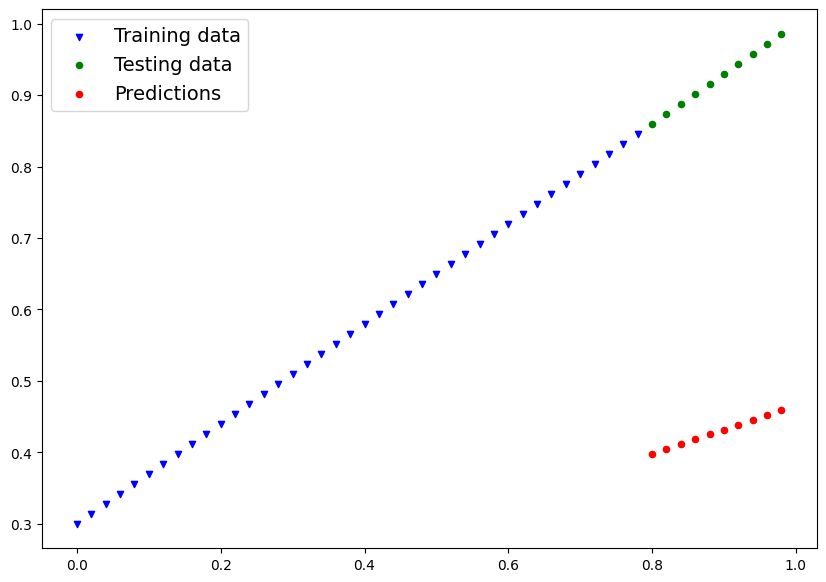

In [176]:
plot_predictions(predictions=y_preds)
y_test - y_preds


# 3. Train model
Creating a loss function and optimizer in PyTorch

For the model to update its parameters on its own, it needs to add a loss function and an optimizer

**Function**     **what it does** 

Loss function	Measures how wrong your model's predictions (e.g. y_preds) are compared to the truth labels (e.g. y_test). Lower the better.	
                **Location in Pytorch** PyTorch has plenty of built-in loss functions in torch.nn.	Mean absolute error (MAE) for regression problems (torch.nn.L1Loss()). 
                **Common Values** Binary cross entropy for binary classification problems (torch.nn.BCELoss()).
                
                                                                                                        **Location in Pytorch**                                                  **Common Values**

Optimizer	  Tells your model how to update its internal parameters to best lower the loss.	You can find various optimization function implementations in torch.optim.	Stochastic gradient descent (torch.optim.SGD()). Adam optimizer (torch.optim.Adam()).
Let's create a loss function a

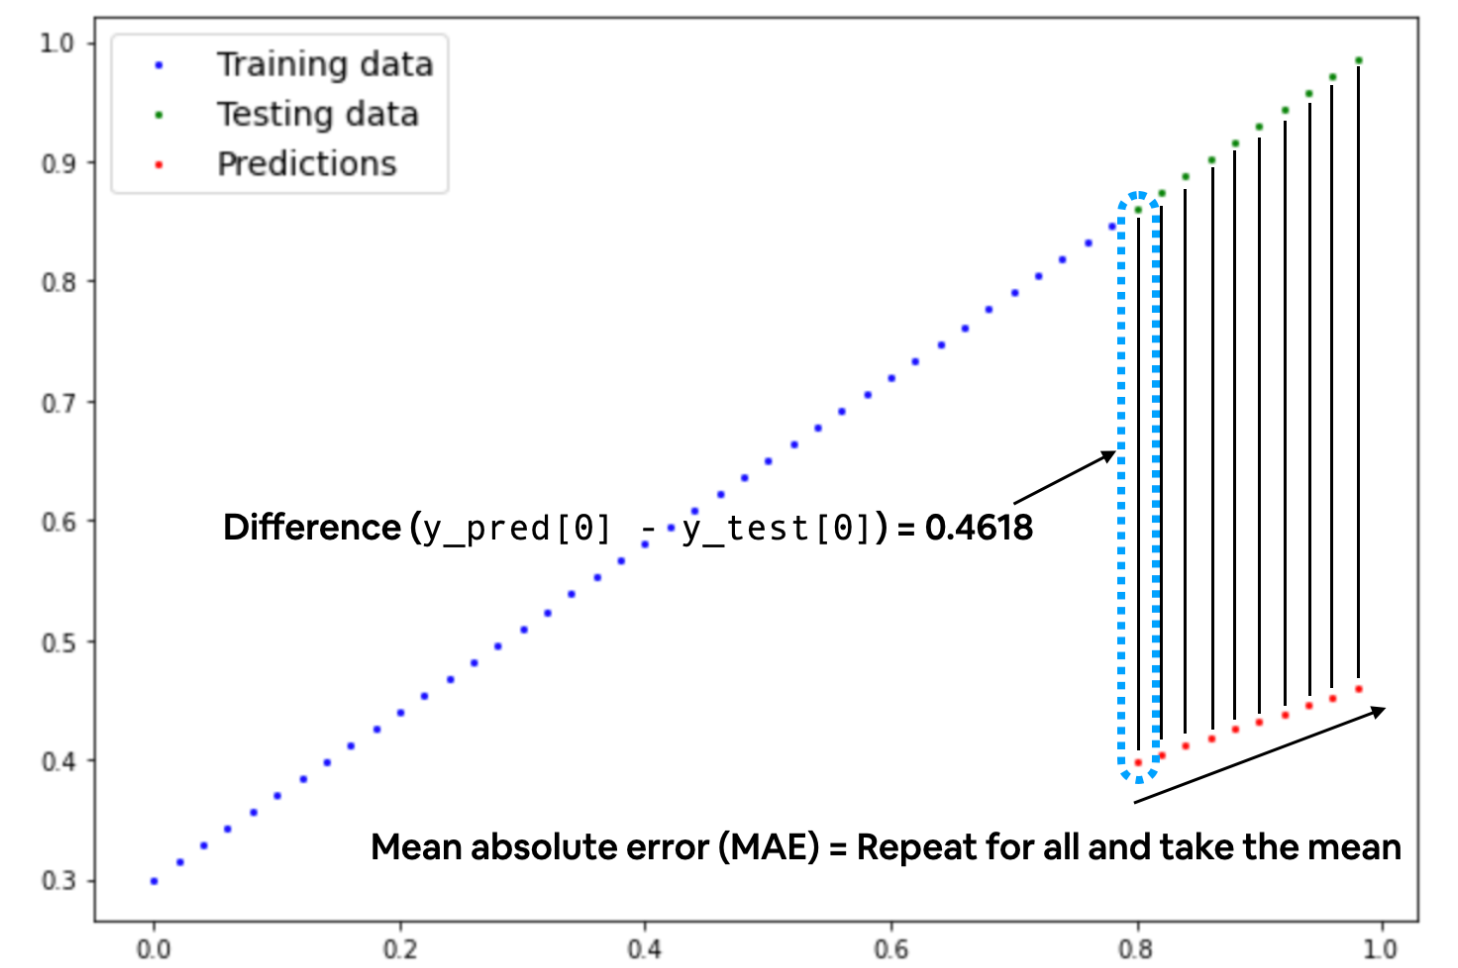

Type of Loss function utlized in model  depends on Type of problem 
Optimizer 

In [177]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time)) Learning rate is hypreparameter

**Training Loop**
learning the relationships between the features and labels

**testing Loop**
The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never sees the testing data during training).

**Steps to remember**

Its training time

Do the forward pass

Calculate the Loss

Optimizer zerograd

Loss Backwards


Optimizer step

**Lets test Now**

With torch no grad

Do the forward pass

Calculate the loss

Watch it go down.....


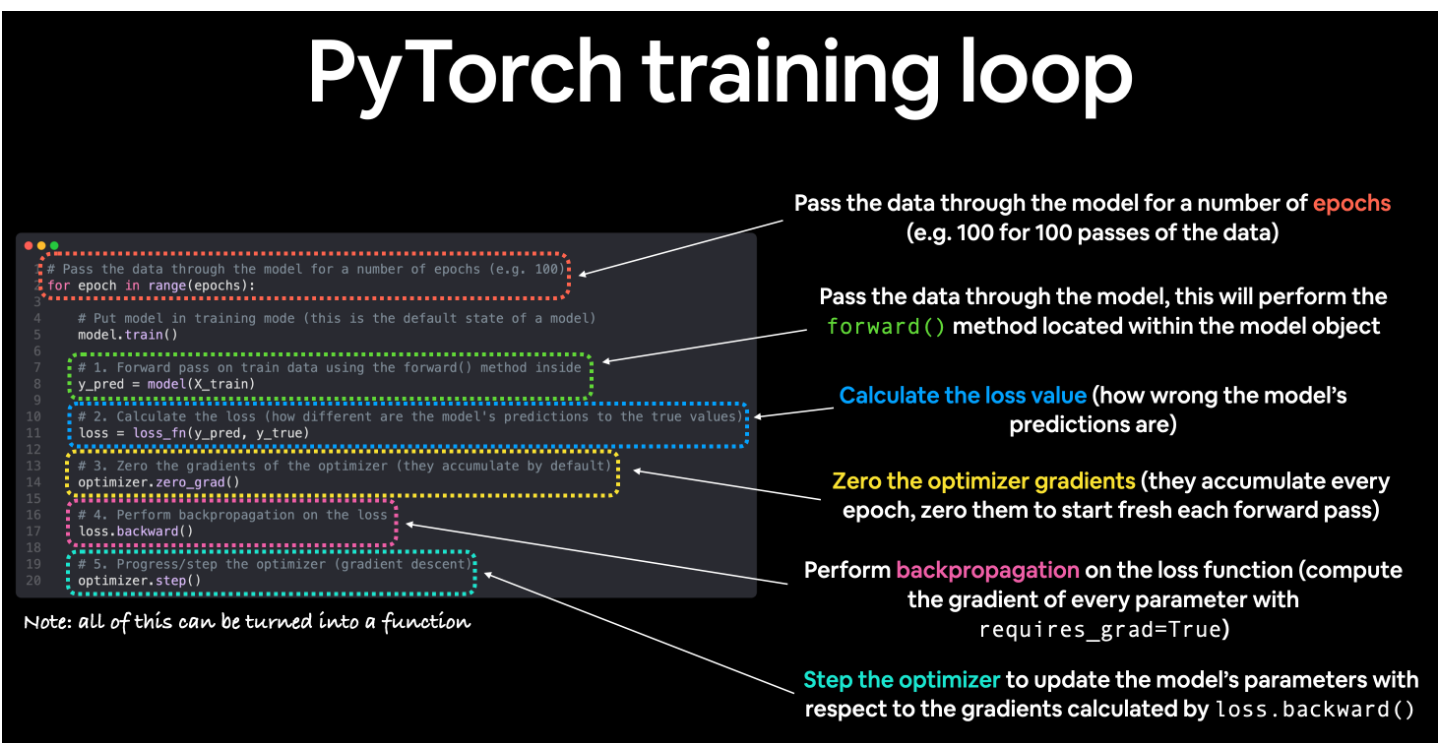  ,  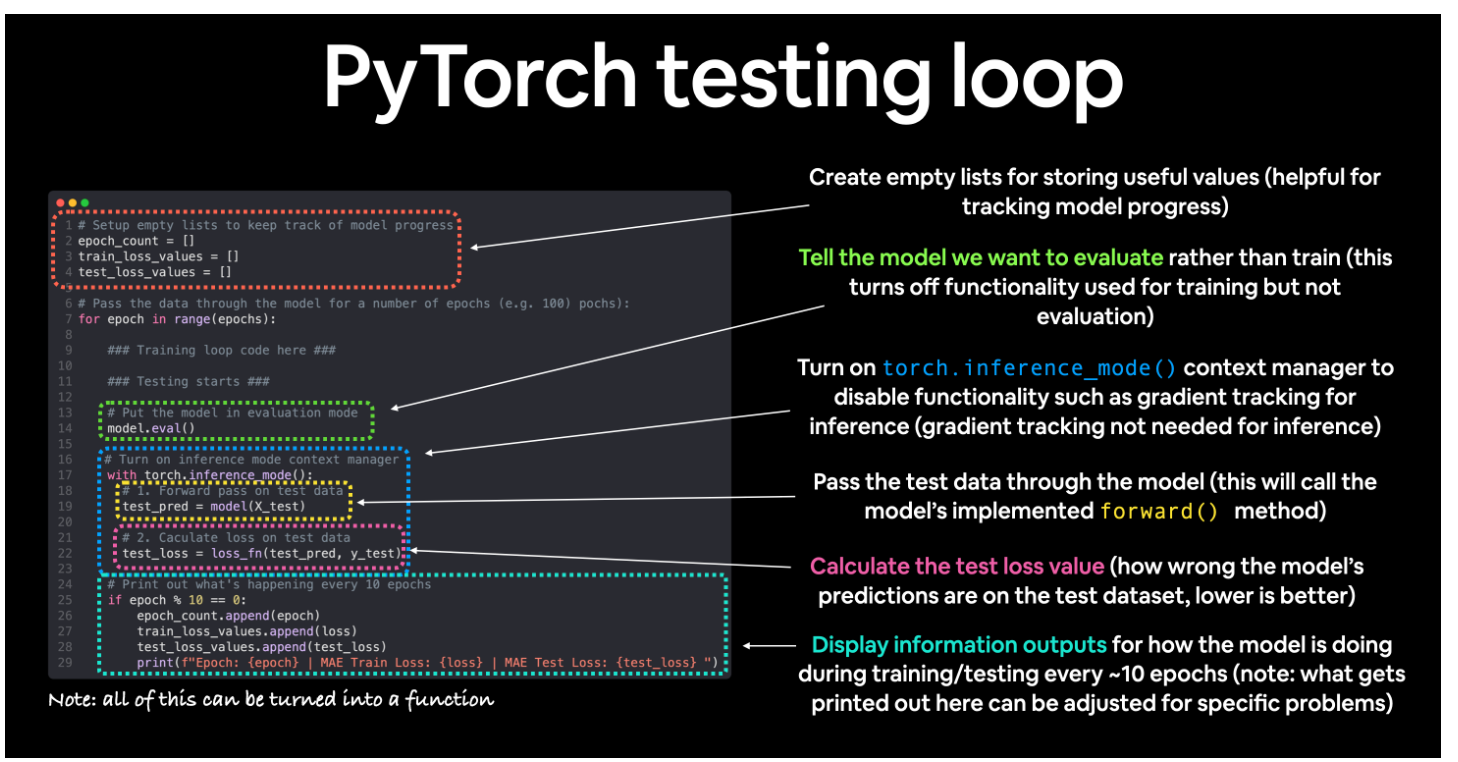

In [178]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 


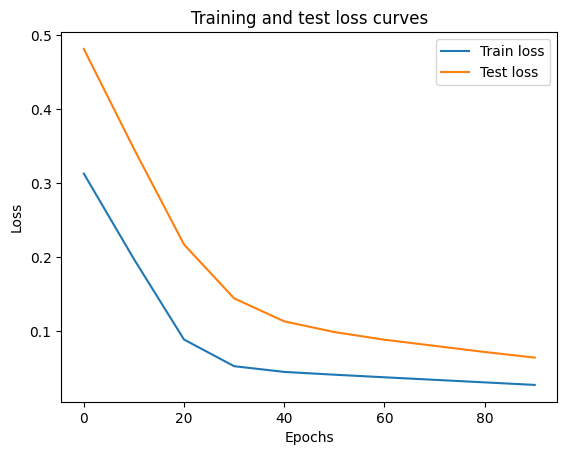

In [179]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

inspect model's .state_dict() to see how close the model gets to the original values we set for weights and bias.

In [180]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


**Exercise:** Try changing the epochs value above to 200, what happens to the loss curves and the weights and bias parameter values of the model?

The whole idea of machine learning and deep learning is that there are some ideal values that describe our data and rather than figuring them out by hand, we can train a model to figure them out programmatically.

# 4. Making predictions with a trained PyTorch model (inference)

Three things to remember when making predictions (also called performing inference) with a PyTorch model

1) Set the model in evaluation mode (model.eval()).

2) Make the predictions using the inference mode context manager (with torch.inference_mode(): ...).

3)  All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only)


In [181]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

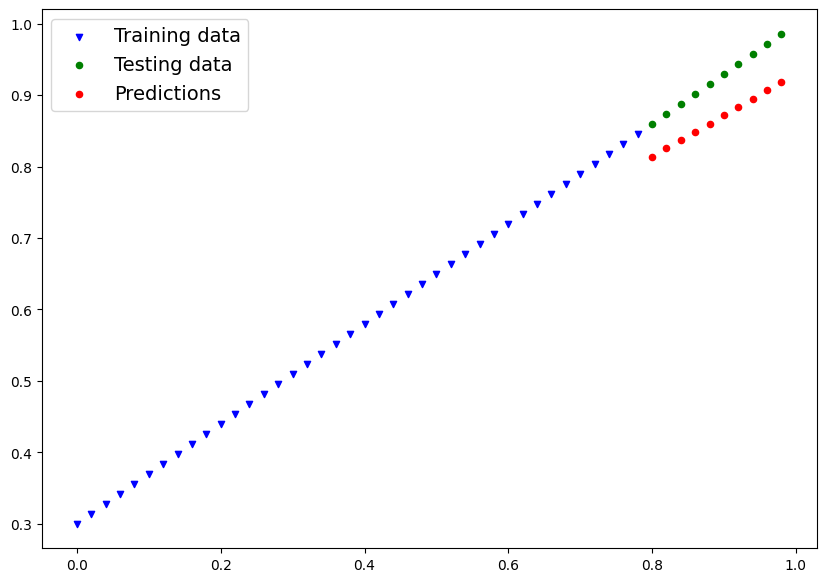

In [182]:
plot_predictions(predictions=y_preds)


# 5. Saving and loading a PyTorch model

Why save model:

1).  to save it and export it somewhere.
2). or like to save your progress on a model and come back and load it back 

**PyTorch method**	  and      **What does it do?**

torch.save	    Saves a serialized object to disk using Python's pickle utility. Models, tensors and various other Python objects like dictionaries can be saved using torch.save.

torch.load	    Uses pickle's unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc).

torch.nn.Module.load_state_dict 	Loads a model's parameter dictionary (model.state_dict()) using a saved state_dict() object.


**Saving a PyTorch model's state_dict()** (This module is recommended!!!)

**1).**  create a directory for saving models to called models using Python's pathlib module.

**2).** create a file path to save the model to.

**3).**  call torch.save(obj, f) where obj is the target model's state_dict() and f is the filename of where to save the model.

**Note:** It's common convention for PyTorch saved models or objects to end with .pt or .pth, like saved_model_01.pth.


In [183]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "First_Pytorch_DeeplearningModel.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME


# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models\First_Pytorch_DeeplearningModel.pth


In [184]:
import os

#file_path = "models/01_pytorch_workflow_model_0.pth"
if os.path.exists(MODEL_SAVE_PATH):
    print("File exists:", MODEL_SAVE_PATH )
else:
    print("File not found:", MODEL_SAVE_PATH )



File exists: models\First_Pytorch_DeeplearningModel.pth


# Loading a saved PyTorch model's state_dict()


In [185]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH, weights_only=True))

<All keys matched successfully>

# PyTorch inference rules

Set the model in evaluation mode (model.eval()).

Make the predictions using the inference mode context manager (with torch.inference_mode(): ...).

All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

In [186]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [187]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# classification Problem.
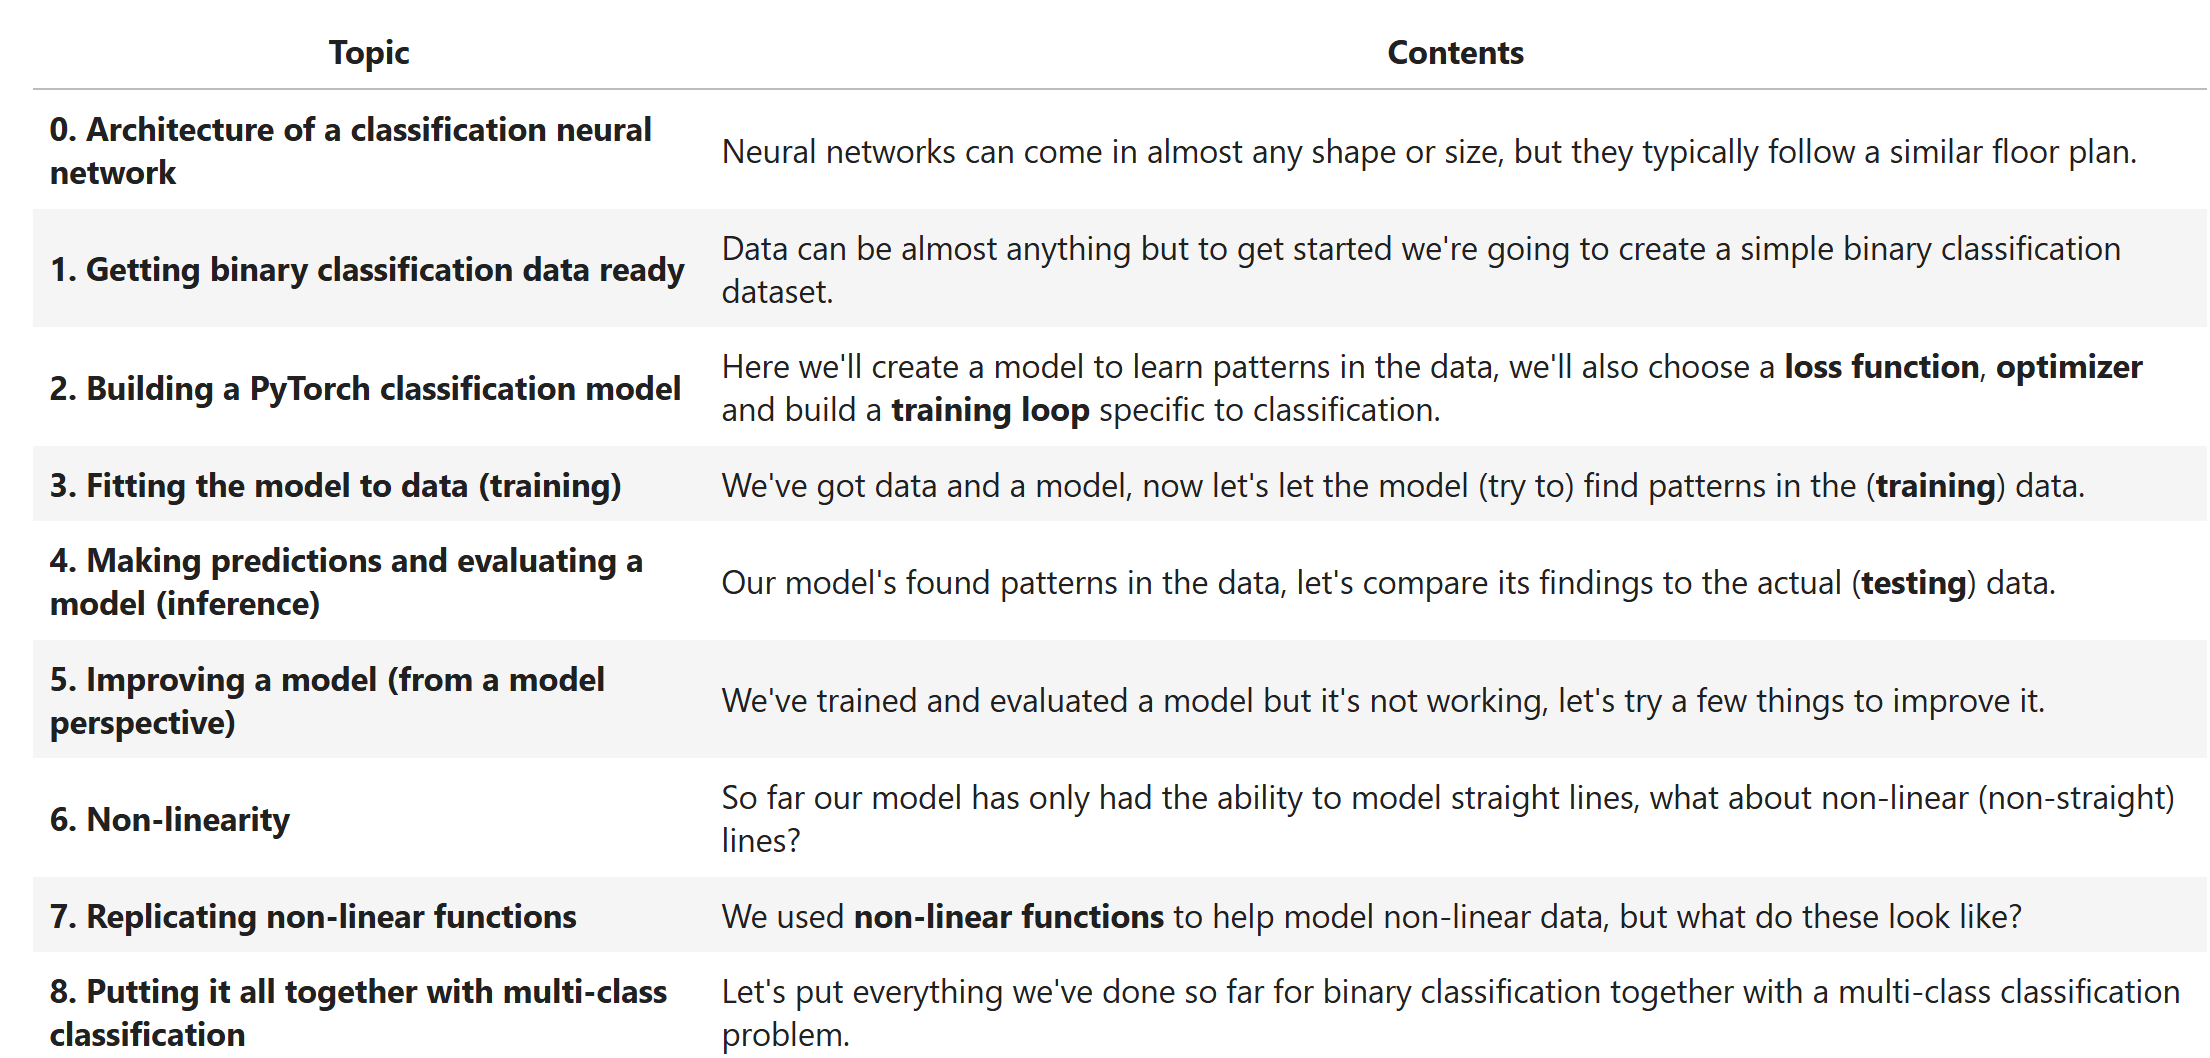

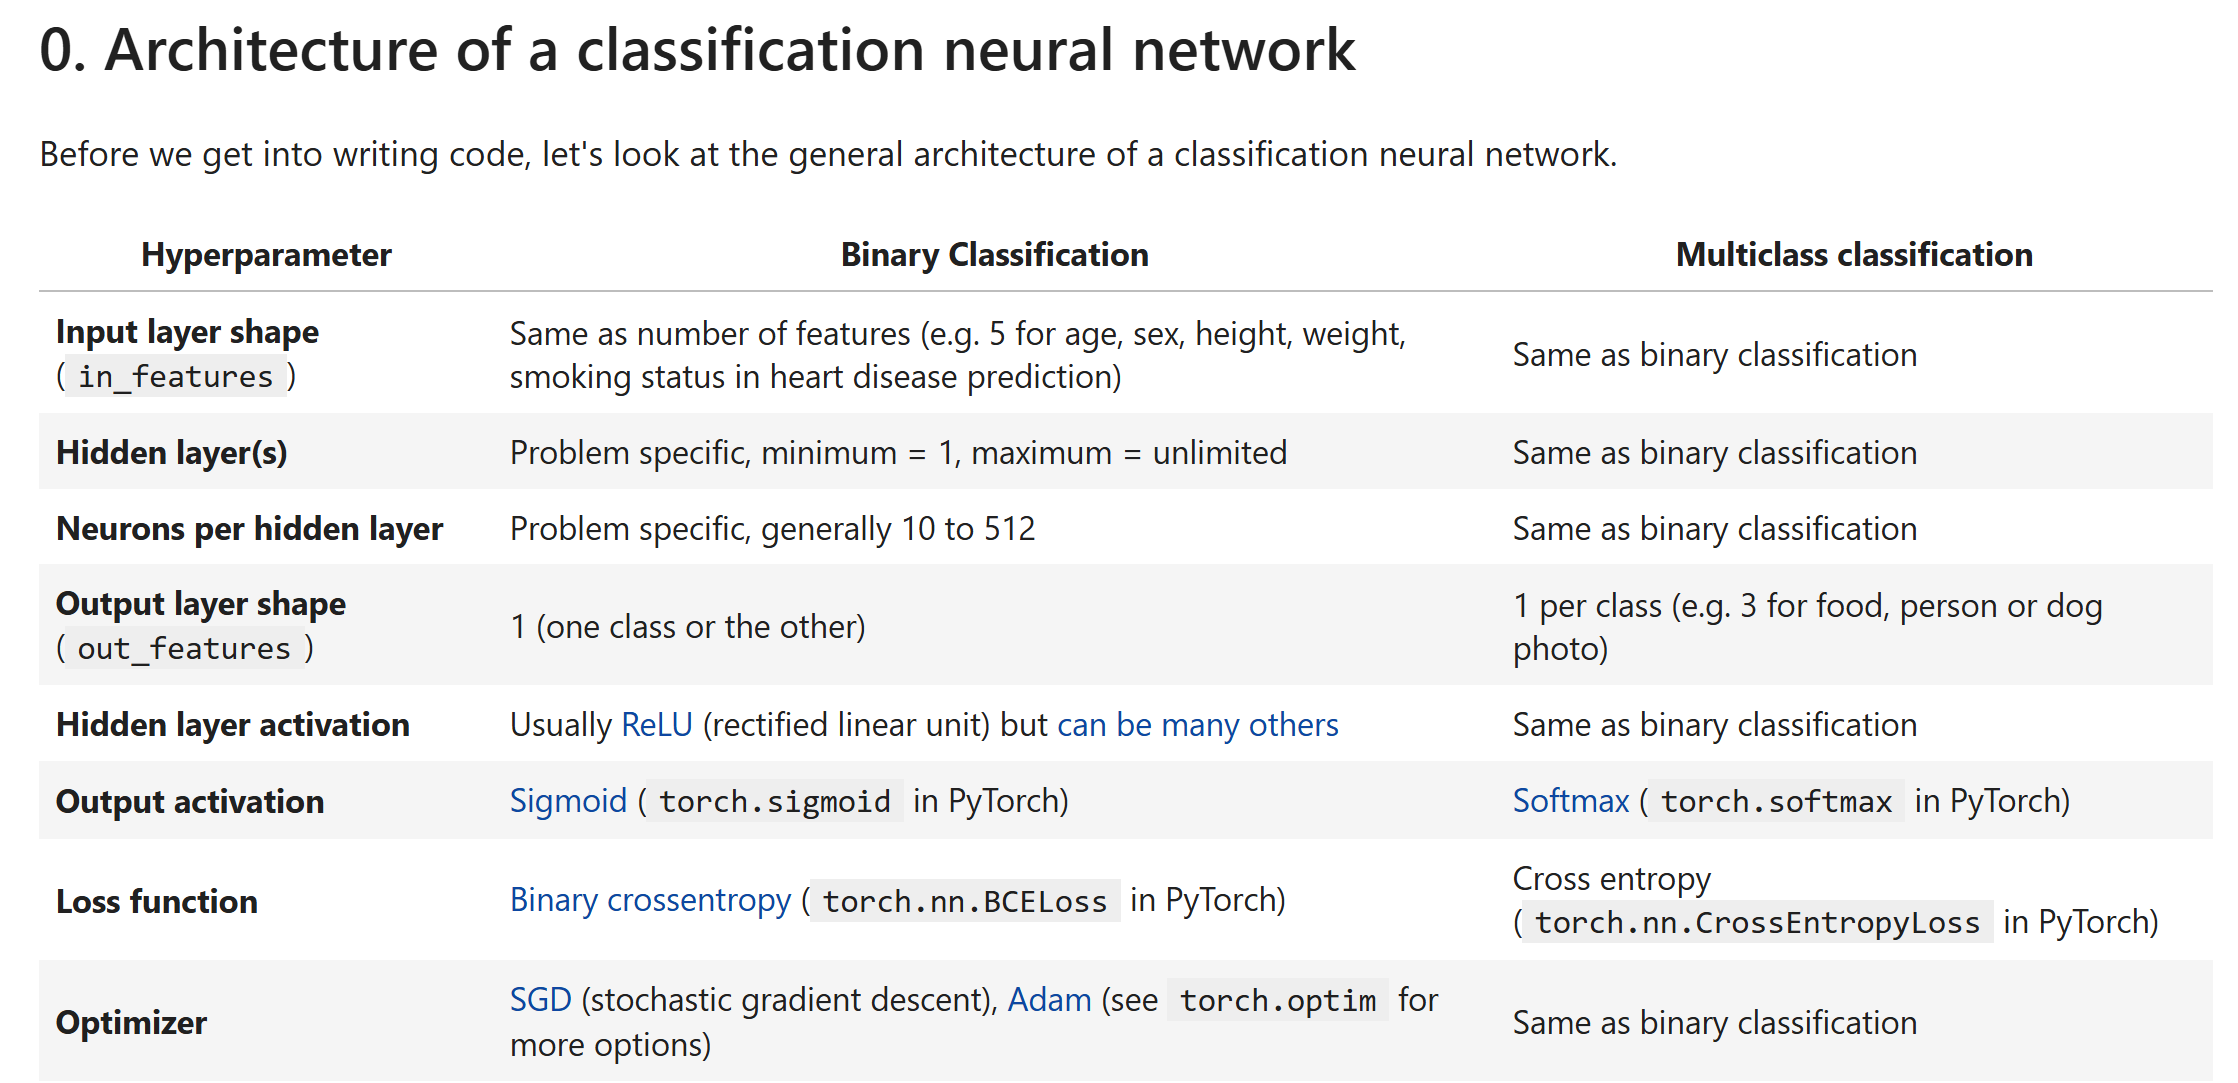

# Make Classification data Ready


First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]], X Shape: (1000, 2)

First 5 y labels:
[1 1 1 1 0], y Shape(1000,)


 dataset in dataframe

          X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0
5 -0.479646  0.676435      1
6 -0.013648  0.803349      1
7  0.771513  0.147760      1
8 -0.169322 -0.793456      1
9 -0.121486  1.021509      0 




 This is Label count through dataframelabel
1    500
0    500
Name: count, dtype: int64

 And this is Label count through torch[500 500]


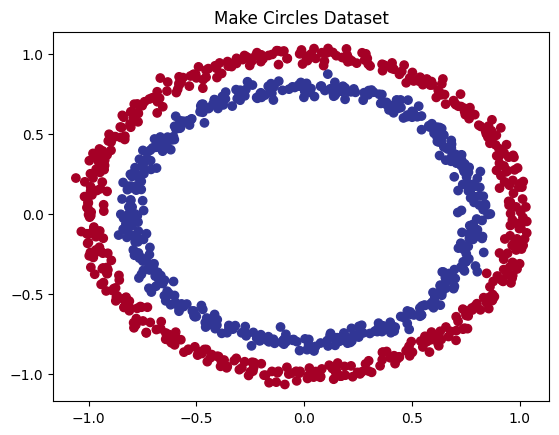

In [3]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

print(f"First 5 X features:\n{X[:5]}, X Shape: {X.shape}")
print(f"\nFirst 5 y labels:\n{y[:5]}, y Shape{y.shape}")

#label_counts = torch.bincount(y)


# OR
# Make DataFrame of circle data

circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
print("\n\n dataset in dataframe\n\n",circles.head(10),"\n\n")



# Visualize with a plot generated Circles

plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);
plt.title("Make Circles Dataset")
print(f"\n\n This is Label count through dataframe{circles.label.value_counts()}\n\n And this is Label count through torch{np.bincount(y)}")

1.2 Turn data into tensors and create train and test splits



In [4]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)






##--------------------OR ----------------------------#

# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 

X_train, y_train = X[:train_split], y[:train_split]

X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(X_test), len(y_train), len(y_test)



In [5]:
#torch.manual_seed(42)
#train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 

#X_train, y_train = X[:train_split], y[:train_split]

#X_test, y_test = X[train_split:], y[train_split:]

#len(X_train), len(X_test), len(y_train), len(y_test)
#X_train[1]
# OUTPUT: (800, 200, 800, 200)

In [6]:

# Split data into train and test sets


X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    shuffle=False) # make the random split reproducible  
                                                    # I have removed random_state=42

len(X_train), len(X_test), len(y_train), len(y_test)
X_train[1]

# (800, 200, 800, 200)

tensor([-0.7562,  0.1533])

In [7]:
# IMPORTANCE OF random_state IN train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible  
                                                    # I have removed random_state=42

len(X_train), len(X_test), len(y_train), len(y_test)
X_train[1]

tensor([ 0.6319, -0.7347])

In [8]:
# IMPORTANCE OF random_state IN train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible  
                                                    # I have removed random_state=42

len(X_train), len(X_test), len(y_train), len(y_test)
X_train[1]

tensor([ 0.6319, -0.7347])

**Create a model class**

1). Subclasses nn.Module (almost all PyTorch models are subclasses of nn.Module).

2). Creates 2 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.

3).  Defines a forward() method containing the forward pass computation of the model.

4). Instantiates the model class and sends it to the target device.

In [9]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)
    
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0()
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

The  5 hidden units or neurons turns the input data from having 2 features to 5 features

To allows the model to learn patterns from 5 numbers rather than just 2 numbers, potentially leading to better outputs.

The number of hidden units you can use in neural network layers is a hyperparameter 

 go and check TensorFlow Playground website for creating visual models.

In [10]:
# Make predictions with the model
untrained_preds = model_0(X_test)
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.6111],
        [-0.7921],
        [-0.0601],
        [-0.7675],
        [ 0.0609],
        [-0.0505],
        [-0.6563],
        [-0.4824],
        [-0.0661],
        [-0.8029]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


#  Setup loss function and optimizer
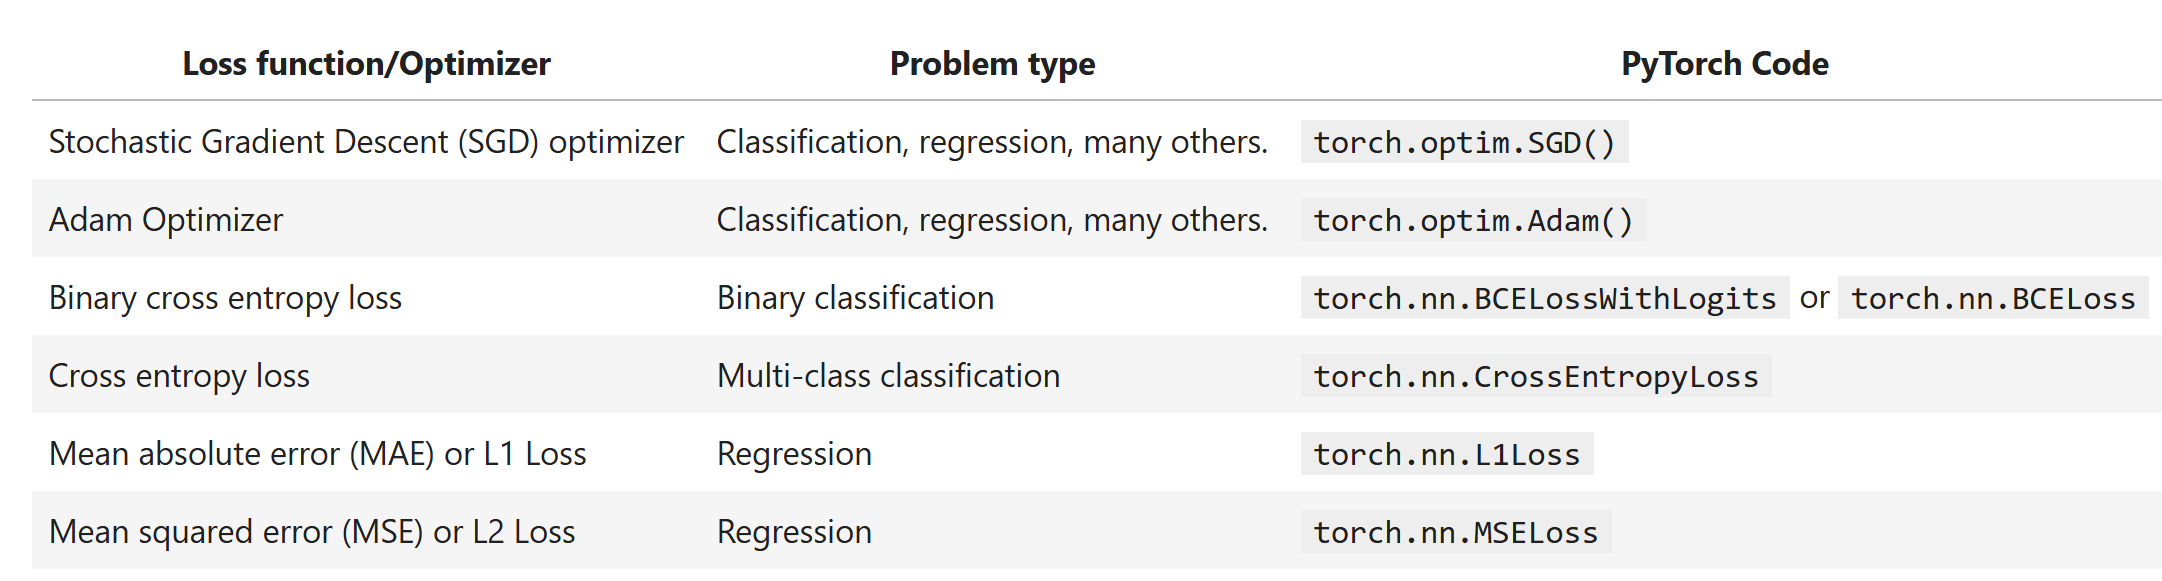

In [11]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

#  Creating evaluation metric Accuracy

In [12]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

# Train model

In [15]:
 #View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test)[:5]
y_logits

tensor([[-0.6111],
        [-0.7921],
        [-0.0601],
        [-0.7675],
        [ 0.0609]], grad_fn=<SliceBackward0>)

In [16]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3518],
        [0.3117],
        [0.4850],
        [0.3170],
        [0.5152]], grad_fn=<SigmoidBackward0>)

In [19]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test)[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 1.], grad_fn=<SqueezeBackward0>)

In [20]:
y_test[:5]


tensor([1., 0., 1., 0., 1.])

# Building a training and testing loop

In [21]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train, y_train
X_test, y_test = X_test, y_test

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71987, Accuracy: 46.38% | Test loss: 0.70740, Test acc: 50.00%
Epoch: 10 | Loss: 0.71135, Accuracy: 47.00% | Test loss: 0.69984, Test acc: 52.50%
Epoch: 20 | Loss: 0.70660, Accuracy: 48.00% | Test loss: 0.69598, Test acc: 51.00%
Epoch: 30 | Loss: 0.70365, Accuracy: 48.00% | Test loss: 0.69387, Test acc: 51.00%
Epoch: 40 | Loss: 0.70165, Accuracy: 47.75% | Test loss: 0.69266, Test acc: 53.00%
Epoch: 50 | Loss: 0.70021, Accuracy: 48.00% | Test loss: 0.69193, Test acc: 53.00%
Epoch: 60 | Loss: 0.69910, Accuracy: 48.25% | Test loss: 0.69150, Test acc: 53.00%
Epoch: 70 | Loss: 0.69823, Accuracy: 48.62% | Test loss: 0.69123, Test acc: 53.00%
Epoch: 80 | Loss: 0.69752, Accuracy: 48.88% | Test loss: 0.69108, Test acc: 53.00%
Epoch: 90 | Loss: 0.69694, Accuracy: 48.62% | Test loss: 0.69101, Test acc: 53.00%


# Make predictions and evaluate the model

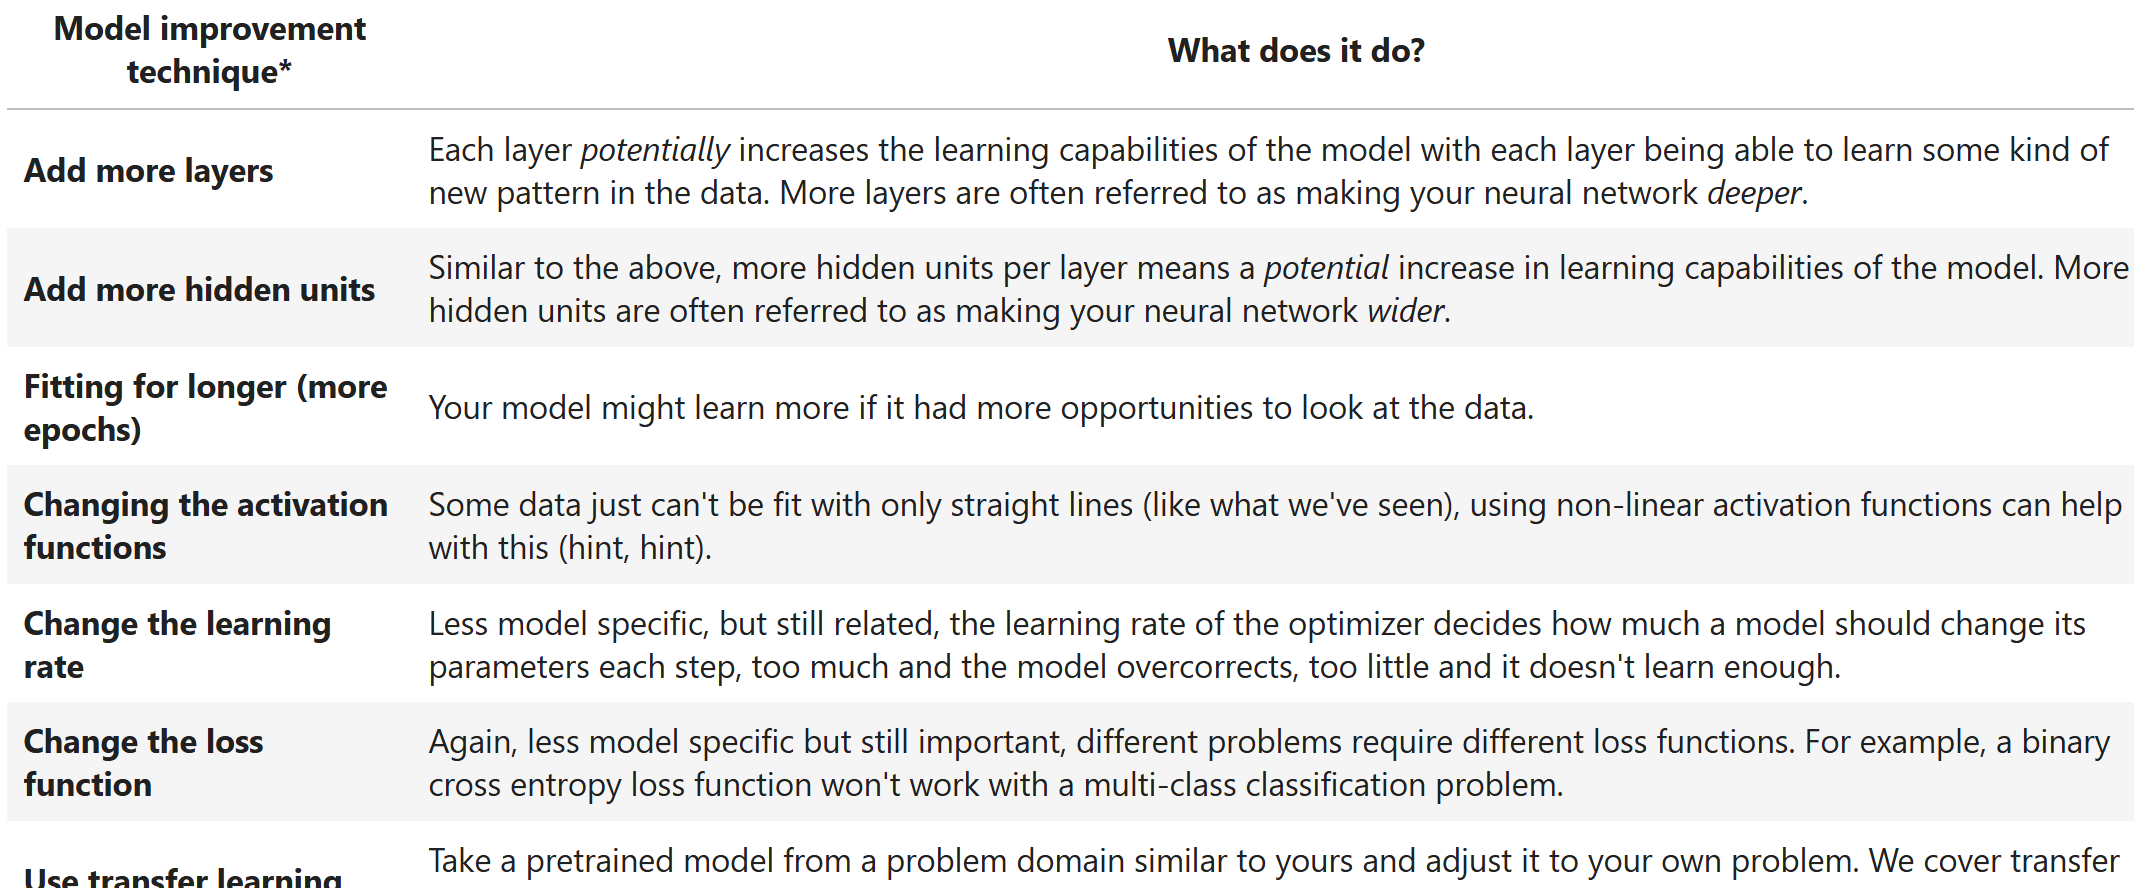